In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.random import seed
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed

import torch
from torch import nn
    
from sklearn.metrics import confusion_matrix

import time
import sys
sys.path.append("..")


# Set randomness for reproducibility
seed(1234)
set_seed(1234)

2023-07-10 14:32:44.630060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-10 14:32:44.630081: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_explanation(input_df):
    df_res = input_df.iloc[::-1]

    text = df_res.values.copy()
        
    z = df_res.values.copy()
    z[-1, ::] = 0
    z[1, ::] = (np.max(z[1, ::]) - z[1, ::])*100
    z[0, ::] = (z[0, ::])*np.max(z[1, ::])



    fig = go.Figure(data=go.Heatmap(
            showscale=False,
            colorscale="greens",
            z=z,
            text=text,
            texttemplate="%{text}",
            textfont={"size":20}),
                   )

    fig.update_yaxes(tickangle=0,
                     tickvals = [0,1,2,3],
                     ticktext= ["True Explanation", "Explanation Order", "Data", "Variable"])
    fig.update_xaxes(showticklabels=False) # Hide x axis ticks 



    fig.update_layout(
        autosize=False,
        width=900,
        height=400,
        title={
            'text': r"$X5 = (X2 - X1)/2 + 0.5 \text{   AND   } X6 = (X4 + X3)/2$",
            'y':0.8,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    fig.show()

In [3]:
def draw_uniform_discret_01(n_quantization, size):
    val = np.linspace(0,1,n_quantization)
    x = np.random.choice(val, size=size)
    return x

In [23]:
def create_model(input_dim, lr=1e-4, loss="binary_crossentropy"):
    LATENT_SIZE = input_dim * 1/3

    encoder = Sequential([
        Dense(input_dim*2/3),
        LR(),
        Dense(LATENT_SIZE, activation="sigmoid"),
    ])

    decoder = Sequential([
        Dense(input_dim*2/3),
        LR(),
        Dense(input_dim),
        Activation("sigmoid"),
    ])

    img = Input(shape = (input_dim))
    latent_vector = encoder(img)
    output = decoder(latent_vector)
    model = Model(inputs = img, outputs = output)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, loss = loss)
    return model

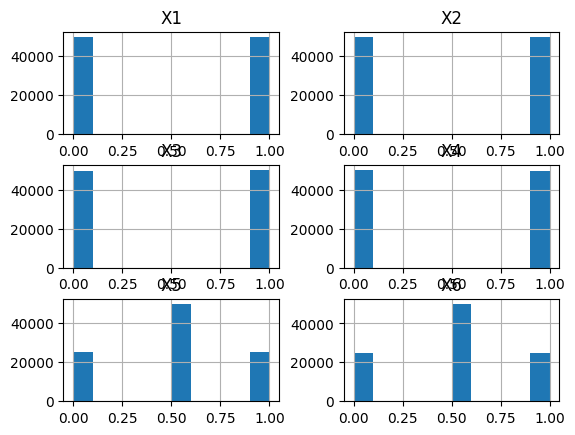

In [24]:
# Create Dataset
n_samples = 100_000
X1 = draw_uniform_discret_01(2, n_samples)
X2 = draw_uniform_discret_01(2, n_samples)
X3 = draw_uniform_discret_01(2, n_samples)
X4 = draw_uniform_discret_01(2, n_samples)
X5 = (X2 - X1)/2 + 0.5
X6 = (X4 + X3)/2

X = np.vstack([X1, X2, X3, X4, X5, X6]).T

df_X = pd.DataFrame(X, columns=["X"+str(no+1) for no in range(X.shape[1])])
dim_features = df_X.columns
dim  = len(dim_features)

# Some visualisation
df_X.hist()
plt.show()

In [25]:
# Train Test Split
n = len(X)

nb_train = int((2/3)*n//2)
x_train = X[:nb_train]
y_train = np.array([0]*nb_train).ravel()

x_valid = X[nb_train:n//2]
nb_valid = len(x_valid)
y_valid = np.array([0]*nb_valid).ravel()

x_test = X[n//2:]
nb_test = len(x_test)
y_test = np.array([0]*nb_test).ravel()

print("train:", x_train.shape, "\nvalidation:", x_valid.shape, "\ntest:", x_test.shape)

train: (33333, 6) 
validation: (16667, 6) 
test: (50000, 6)


In [26]:
# Noise injection in test
prop_anomalies = 1/100
nb_anomalies = int(np.ceil(prop_anomalies * nb_test))
print("#Anomaly :", nb_anomalies, "/", nb_test, "test samples")
pos = np.random.randint(0, high=4, size=nb_anomalies)
id_pos = list(range(nb_anomalies))
x_test_noisy = x_test.copy()
x_test_noisy[id_pos, pos] = 1 - x_test[id_pos, pos]
y_test[id_pos] = 1

#Anomaly : 500 / 50000 test samples


In [27]:
diff = (x_test_noisy - x_test)
print(diff)
np.abs(diff).sum(axis=0), np.abs(diff).sum(axis=1), np.max(np.abs(diff).sum(axis=1))

[[ 0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 ...
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


(array([125., 124., 129., 122.,   0.,   0.]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 1.0)

----------- EPOCH 0 -----------
261/261 [==============================] - 1s 2ms/step - loss: 0.6904 - val_loss: 0.6698
----------- EPOCH 1 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.6216 - val_loss: 0.5737
----------- EPOCH 2 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.5560 - val_loss: 0.5420
----------- EPOCH 3 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.5346 - val_loss: 0.5276
----------- EPOCH 4 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.5222 - val_loss: 0.5138
----------- EPOCH 5 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.5000 - val_loss: 0.4817
----------- EPOCH 6 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.4622 - val_loss: 0.4459
----------- EPOCH 7 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.4357 - val_loss: 0.4266
----------- EPOCH 8 -----------


261/261 [==============================] - 0s 1ms/step - loss: 0.2836 - val_loss: 0.2834
----------- EPOCH 68 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2829 - val_loss: 0.2826
----------- EPOCH 69 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2822 - val_loss: 0.2819
----------- EPOCH 70 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2815 - val_loss: 0.2812
----------- EPOCH 71 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2808 - val_loss: 0.2806
----------- EPOCH 72 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2802 - val_loss: 0.2800
----------- EPOCH 73 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2796 - val_loss: 0.2793
----------- EPOCH 74 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2789 - val_loss: 0.2787
----------- EPOCH 75 -----------
261/261 [===============

261/261 [==============================] - 0s 1ms/step - loss: 0.2155 - val_loss: 0.2142
----------- EPOCH 135 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2141 - val_loss: 0.2128
----------- EPOCH 136 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2126 - val_loss: 0.2112
----------- EPOCH 137 -----------
261/261 [==============================] - 0s 2ms/step - loss: 0.2109 - val_loss: 0.2096
----------- EPOCH 138 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2092 - val_loss: 0.2079
----------- EPOCH 139 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2075 - val_loss: 0.2062
----------- EPOCH 140 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2057 - val_loss: 0.2043
----------- EPOCH 141 -----------
261/261 [==============================] - 0s 1ms/step - loss: 0.2039 - val_loss: 0.2027
----------- EPOCH 142 -----------
261/261 [=======

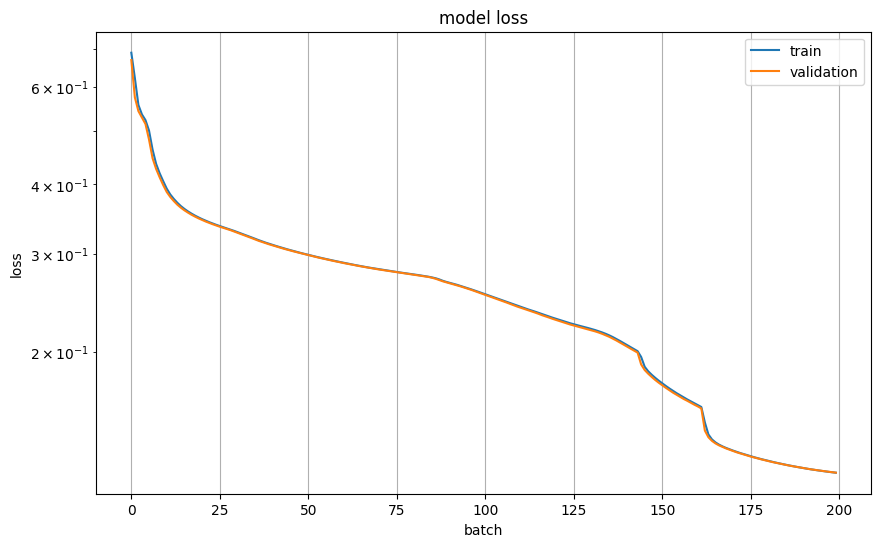

In [28]:
# Define AE model
lr = 1e-3

model = create_model(dim, lr=lr)


# Train AE model
EPOCHS = 200

historyLoss = []
historyValLoss = []
for epoch in range(EPOCHS):
    print("-----------", "EPOCH", epoch, "-----------")
    history = model.fit(x=x_train,
                            y=x_train,
                            shuffle=True,
                            batch_size=128,
                            validation_data=(x_valid, x_valid),
                            verbose=1).history

    historyLoss = historyLoss + history["loss"]
    historyValLoss = historyValLoss + history["val_loss"]

fig = plt.figure(figsize=(10, 6))
plt.plot(historyLoss)
plt.plot(historyValLoss)
plt.title('model loss')
plt.yscale('log')
plt.grid()
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'validation'], loc='upper right')

# Save AE Model
model.save("./outputs/model")

In [29]:
# Load Model
model = create_model(dim, lr=lr)
model.load_weights("./outputs/model")

2023-07-10 14:41:34.558950: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./outputs/model: FAILED_PRECONDITION: outputs/model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [30]:
# Anomaly Detection
rec_x_train = model(x_train)
rec_x_test = model(x_test_noisy)
rec_error = np.abs(rec_x_test - x_test_noisy)
anomaly_score = np.mean(rec_error, axis=1)

In [31]:
# Save data if needed later
np.save("./outputs/x_train.npy", x_train)
np.save("./outputs/x_test.npy", x_test)
np.save("./outputs/x_test_noisy.npy", x_test_noisy)
np.save("./outputs/rec_x_train.npy", rec_x_train)
np.save("./outputs/rec_x_test.npy", rec_x_test)

In [32]:
# Anomaly score histogram
df = pd.DataFrame()
df["labels"] = y_test.ravel()
df["scores"] = anomaly_score
fig = px.histogram(df, x="scores", color="labels", nbins=100, barmode="overlay", log_y=True)
fig.show()

In [14]:
# Thresholding for classification
thresh = 0.25
df["pred"] = anomaly_score > thresh

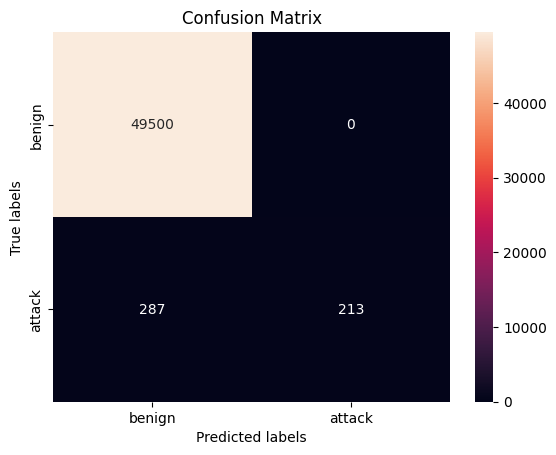

In [15]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_true=df["labels"], y_pred=df["pred"])

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
labels = ['benign', 'attack']
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.show()

In [16]:
# Code to compute the explanations

from ae_pvalues import ae_pvalues

t0 = time.time()
order, pvalues = ae_pvalues(model, normal_data=x_train, data_to_explain=x_test_noisy, output_folder="outputs")
t1 = time.time()

print("[*] Time to compute explanations:", (t1-t0)/60, "minutes")

[*] Time to compute explanations: 0.12513781785964967 minutes


In [17]:
order.shape, pvalues.shape

((50000, 6), (50000, 6))

In [18]:
# Analyse provided explanations
nb_analyse = 10

anomalies = np.where(y_test==1)[0]

# Take the nb_anayse most abnormal different anomalies
idx = list(pd.DataFrame(np.hstack([x_test_noisy[anomalies], anomaly_score[anomalies].reshape(-1,1)])).groupby(by=[0, 1, 2, 3, 4, 5], as_index=False).max().sort_values(by=[6], ascending=False).index[:nb_analyse])


for i in idx:
    print(i)
    df_res = pd.DataFrame()
    df_res["cols"] = dim_features 
    df_res["data"] = x_test_noisy[anomalies][i]
    df_res["explanations_order"] = order[anomalies][i]
    expl = np.zeros(dim)
    expl[pos[i]] = 1
    df_res["true_explanation"] = expl
    df_res["true_explanation"] = df_res["true_explanation"].astype(int)
    df_res = df_res.T
    plot_explanation(df_res)    

42


38


5


9


44


10


3


37


7


41
